In [36]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
import lightgbm as lgb
from catboost import Pool, CatBoostRegressor, cv, MetricVisualizer

In [2]:
weather = pd.read_csv('data/weather_v1.csv')
target = pd.read_csv('data/target_v1.csv')

C:\Users\user\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# 2. 모델 구축 시 사용할 지점 및 기상 속성 선정 과정

## 사용 지점 (4곳)
- 제주, 고산, 성산, 서귀포 (ASOS 지점)

## 선정 이유
- 전국적으로 ASOS에서 관측한 기온이 공식으로 인정 받기 때문에 ASOS 기온만 사용해볼 것이다.
출처: https://www.hankyung.com/society/article/201807242843Y

- 사용 기상 속성
    - 제주: 기온
    - 고산: 기온
    - 성산: 기온
    - 서귀포: 기온

## 선정 이유
- 기온은 결측값이 가장 적음과 동시에, smp 및 supply와의 상관관계도 기타 속성에 비해 강한 편이다

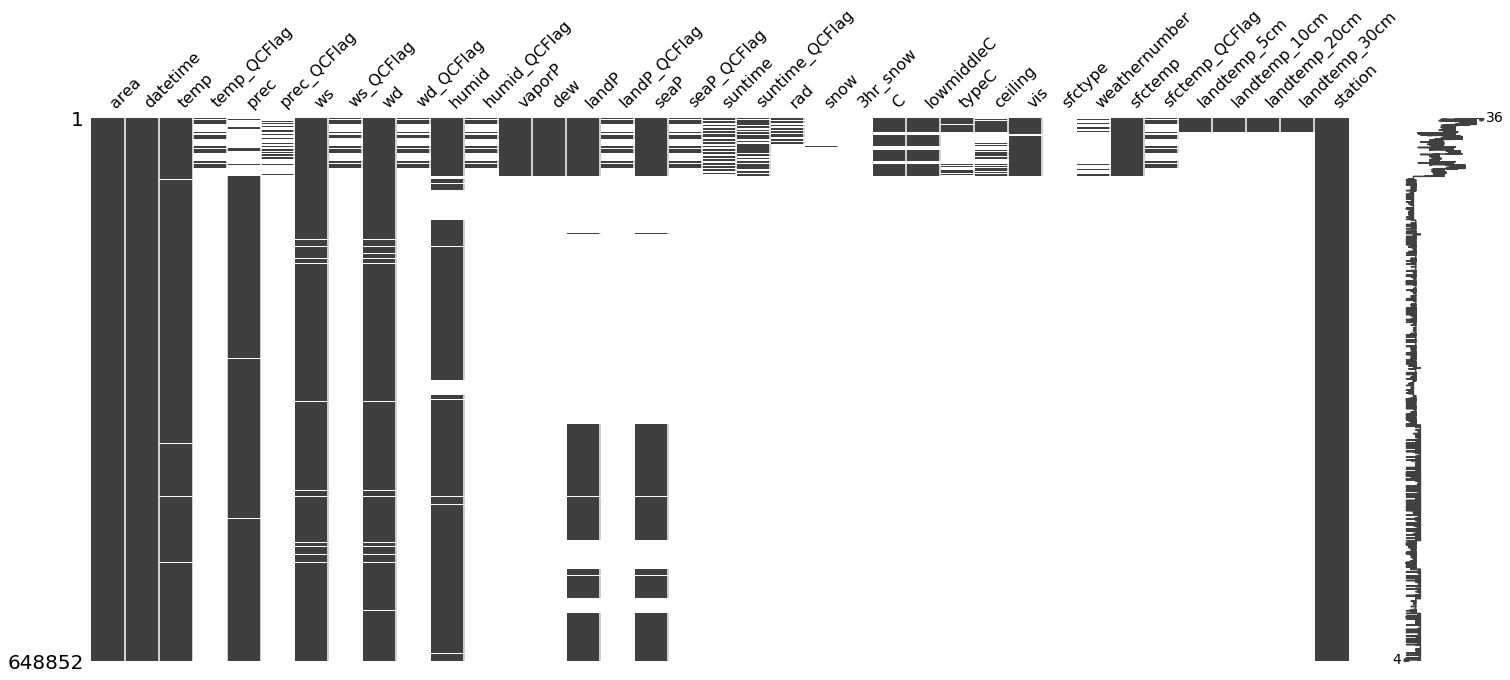

In [3]:
# 결측치 확인
import missingno as msno
msno.matrix(weather)

In [4]:
weather['date'] = weather['datetime'].apply(lambda x : x[:10])
weather_mean = weather.groupby('date').mean().reset_index(drop = True)

In [5]:
# 평균 상관관계 확인 
pd.concat([target,weather_mean], axis = 1).corr().loc['smp_max':'supply','area':].abs().mean().sort_values(ascending = False).head(10)

landtemp_30cm    0.318214
landtemp_5cm     0.294053
landtemp_10cm    0.291533
landtemp_20cm    0.287504
temp             0.283490
sfctemp          0.276526
dew              0.262873
vaporP           0.248143
snow             0.235689
3hr_snow         0.215909
dtype: float64

# 3. 데이터 전처리
## target
- target의 date에서 년, 월, 일, 요일을 찾아 추가


## weather
- ASOS 지역의 기온만을 사용
- 기온는 지역별 기온의 중앙값만을 사용
- 선정된 시간별 기온에서 그 날의 최소기온, 최고기온, 평균기온를 찾아 target에 추가

In [6]:
target['date'] = pd.to_datetime(target['date'])

target['year'] = target['date'].dt.year
target['month'] = target['date'].dt.month
target['day'] = target['date'].dt.day
target['dayofweek'] = target['date'].dt.dayofweek

In [7]:
target.head()

,date,smp_max,smp_min,smp_mean,supply,year,month,day,dayofweek
0,2018-02-01,150.65,116.84,132.71,87.47,2018,2,1,3
1,2018-02-02,163.86,116.84,134.19,86.64,2018,2,2,4
2,2018-02-03,164.07,116.85,131.39,88.28,2018,2,3,5
3,2018-02-04,171.00,115.76,131.89,86.14,2018,2,4,6
4,2018-02-05,170.34,123.89,137.96,90.63,2018,2,5,0


In [8]:
weather = weather[weather['station'] == 'ASOS']

In [9]:
weather['datetime'] = pd.to_datetime(weather['datetime'])
weather = weather.loc[:,'area':'temp']

In [10]:
weather_list = []
for area in weather['area'].unique():
    weather_list.append(weather[weather['area']==area].copy())
    
for i, area in enumerate(weather['area'].unique()):
    weather_list[i].drop(['area'], axis=1, inplace=True)
    weather_list[i].columns = ['datetime', str(area)+'_temp']

In [11]:
start = '2018-02-01'
end = '2020-01-31'
hourly_temperature = pd.DataFrame(columns = ['datetime'])
date_range = pd.date_range(start, end, freq='H')
hourly_temperature['datetime'] = date_range

for d in weather_list:
    hourly_temperature  = hourly_temperature.merge(d, how='outer')
hourly_temperature['median'] = hourly_temperature.median(axis=1)
hourly_temperature = hourly_temperature.loc[:,['datetime', 'median']]
hourly_temperature.columns = ['date', 'temperature']

In [12]:
# 결측치는 1시간 후 온도로 처리
hourly_temperature['temperature'][hourly_temperature['temperature'].isna()] = hourly_temperature.shift(-1)['temperature'][hourly_temperature['temperature'].isna()]

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
start = '2018-02-01'
end = '2020-01-31'
daily_temperature = pd.DataFrame(columns = ['date'])
date_range = pd.date_range(start, end, freq='D')
daily_temperature['date'] = date_range

In [14]:
for d in range(daily_temperature.shape[0]):
    for h in range(24):
        daily_temperature.loc[d, 'temp_h'+str(h)] = hourly_temperature['temperature'][d*24:d*24+24][d*24+h]

In [15]:
daily_temperature['temp_max'] = daily_temperature.loc[:,'temp_h0':].max(axis=1)
daily_temperature['temp_min'] = daily_temperature.loc[:,'temp_h0':].min(axis=1)
daily_temperature['temp_mean'] = daily_temperature.loc[:,'temp_h0':].mean(axis=1)

In [16]:
daily_temperature.head()

,date,temp_h0,temp_h1,temp_h2,temp_h3,temp_h4,temp_h5,temp_h6,temp_h7,temp_h8,...,temp_h17,temp_h18,temp_h19,temp_h20,temp_h21,temp_h22,temp_h23,temp_max,temp_min,temp_mean
0,2018-02-01,3.80,3.80,3.95,3.75,3.35,3.45,3.6,3.65,3.70,...,5.00,4.25,4.15,4.00,3.75,3.40,3.3,5.95,3.30,4.298077
1,2018-02-02,3.20,2.85,2.75,2.60,2.60,2.70,2.6,2.45,2.55,...,4.10,3.85,3.95,3.95,3.85,3.95,4.0,5.25,2.45,3.576923
2,2018-02-03,3.90,4.00,3.80,3.70,3.35,2.75,2.9,1.35,1.55,...,0.30,0.20,0.25,-0.20,-0.50,-0.30,-0.2,4.00,-0.50,1.457692
3,2018-02-04,-0.65,-1.20,-1.35,-0.70,-1.65,-1.55,-1.4,-2.05,-1.60,...,-0.80,-1.00,-0.65,-1.20,-1.00,-1.30,-1.2,0.30,-2.05,-1.000000
4,2018-02-05,-0.95,-1.70,-1.45,-1.15,-0.95,-0.60,-0.2,-0.25,-0.70,...,1.45,1.20,0.10,0.20,0.55,0.15,-0.7,2.05,-1.70,0.015385


In [17]:
target['temp_max'] = daily_temperature['temp_max']
target['temp_min'] =daily_temperature['temp_min']
target['temp_mean'] = daily_temperature['temp_mean']

In [18]:
target.tail()

,date,smp_max,smp_min,smp_mean,supply,year,month,day,dayofweek,temp_max,temp_min,temp_mean
725,2020-01-27,154.46,78.95,94.07,76.64,2020,1,27,0,10.80,8.10,9.700000
726,2020-01-28,156.57,84.80,103.05,80.25,2020,1,28,1,11.00,8.25,9.482692
727,2020-01-29,154.78,86.99,109.21,82.90,2020,1,29,2,10.85,7.80,9.053846
728,2020-01-30,203.15,84.87,112.85,84.85,2020,1,30,3,9.50,6.20,7.719231
729,2020-01-31,205.89,84.80,117.22,86.06,2020,1,31,4,8.05,6.05,6.823077


# 5. 모델 학습 및 검증
- lgbm을 이용하여 2가지 모델 작성

    - 1) 과거 정보를 이용해 supply, 기상정보를 예측하는 모델 (시계열 모델)

    - 2) supply, 기상정보를 이용하여 smp를 예측하는 모델 (상관관계 모델)

- 1)의 모델을 이용해 supply, 기상정보를 예측한 후 2)의 모델로 smp를 예측

In [ ]:
def rmsse(y_true, y_pred, y_hist, axis = None, weight = None):
    '''
    y_true: 실제 값 
    y_pred: 예측 값
    y_hist: 과거 값 (public LB는 v1 기간으로 계산, private LB는 v2 기간으로 계산)
    '''
    
    y_true, y_pred, y_hist = np.array(y_true), np.array(y_pred), np.array(y_hist)
    
    h, n = len(y_true), len(y_hist)


    numerator = np.sum((y_true - y_pred)**2, axis = axis)
    
    denominator = 1/(n-1)*np.sum((y_hist[1:] - y_hist[:-1])**2, axis = axis)
    
    msse = 1/h * numerator/denominator
    
    rmsse = msse ** 0.5
    
    score = rmsse
    
    if weight is not None:
        
        score = rmsse.dot(weight)
    
    return score

In [30]:
def get_trained_model(x_train, y_train, x_val, y_val):
#     x_train = x_train.astype(np.float32)
#     y_train = y_train.astype(np.float32)
#     x_val = x_val.astype(np.float32)
#     y_val = y_val.astype(np.float32)

#     train = lgb.Dataset(x_train, y_train)
#     val = lgb.Dataset(x_val, y_val)
    
    clf = lgb.LGBMRegressor(boosting_type='gbdt', num_leaves=31, max_depth=- 1, learning_rate=0.001, \
                            n_estimators=5000, subsample_for_bin=200000, objective=None, class_weight=None, \
                            min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, \
                            subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, \
                            random_state=7, n_jobs=- 1, silent=True, importance_type='split')
    

    clf.fit(x_train, y_train, eval_set=[(x_val, y_val)], \
            eval_names =["Validation"], \
            eval_metric = ['l1', 'l2'],
            early_stopping_rounds=100, \
            verbose=False)
    
    return clf

In [31]:
def create_model(x_train, y_train, x_val, y_val):
    model = get_trained_model(x_train, y_train, x_val, y_val)
    
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.plot(np.array(y_val), '.-', label='y_val')
    plt.plot(model.predict(x_val), '.-', label='y_pred')
    plt.title(str(future)+'days later')
    plt.legend()
    plt.show()

    return model

In [32]:
def trans(dataset, start_index, end_index, past, future, x_columns, y_columns):
    dataset.index = range(dataset.shape[0])
    data = []
    labels = []
    
    start_index = start_index + past
    
    if end_index is None:
        end_index = dataset.shape[0]
    
    for i in range(start_index, end_index-future):
        indices = np.array(dataset.loc[i-past:i, x_columns])
        data.append(indices)
        
        labels.append(np.array(dataset.loc[i+future, y_columns]))
        
    data = np.array(data)
    data = data.reshape(data.shape[0], -1)
    labels = np.array(labels)
    labels = labels.reshape(-1)
    
    return data, labels

In [33]:
past = 29 # 최근 30일 정보를 이용하여 n일 후를 예측

In [35]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((574, 240), (574,), (30, 240), (30,))

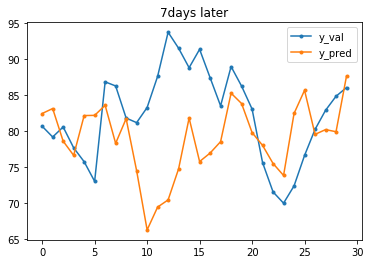

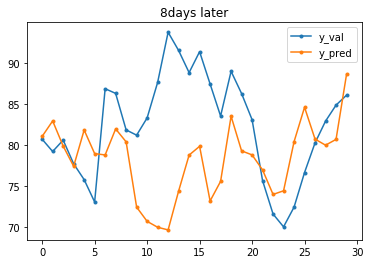

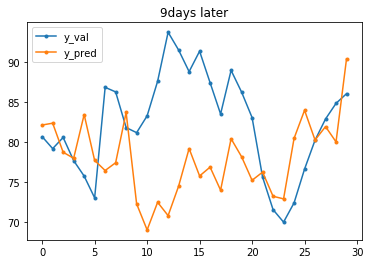

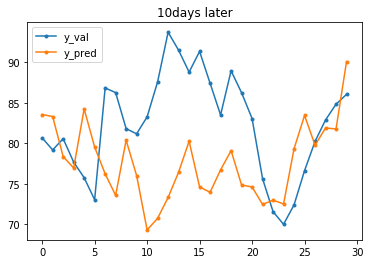

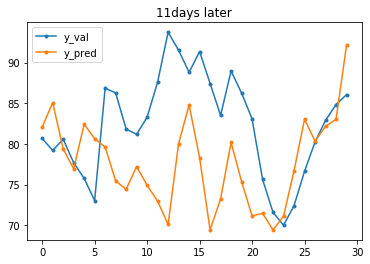

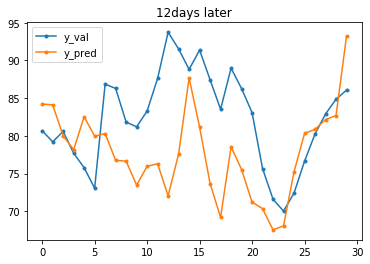

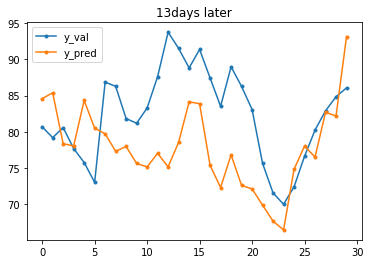

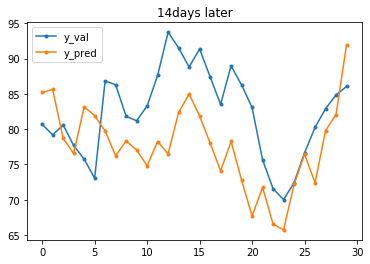

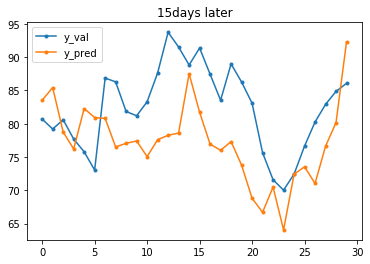

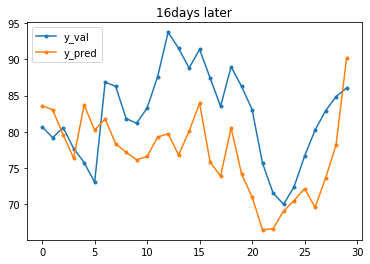

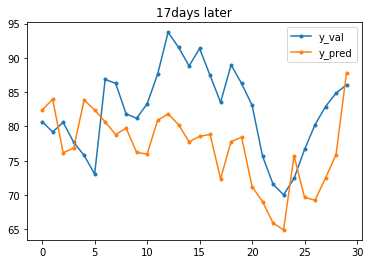

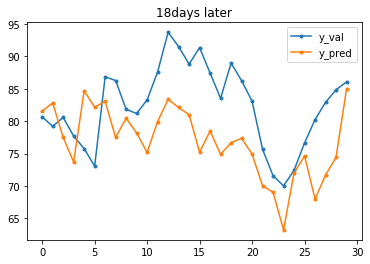

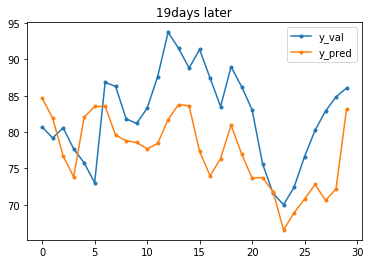

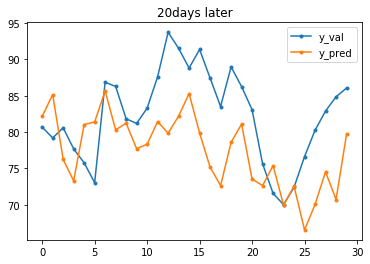

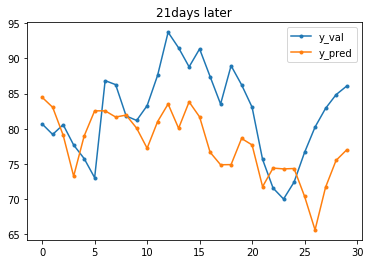

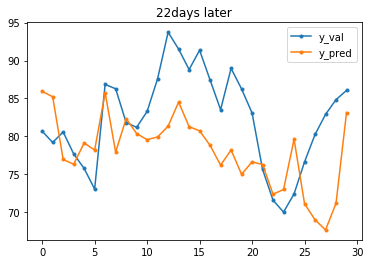

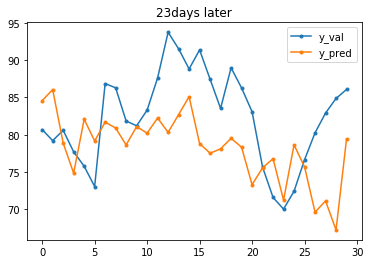

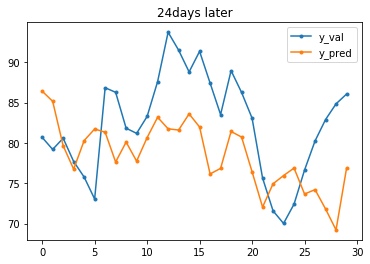

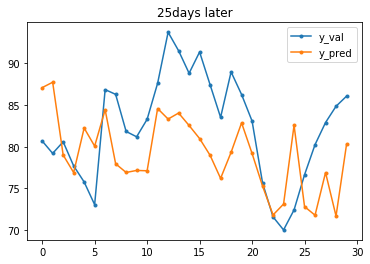

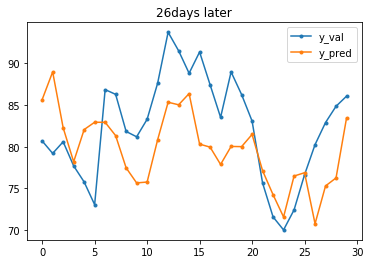

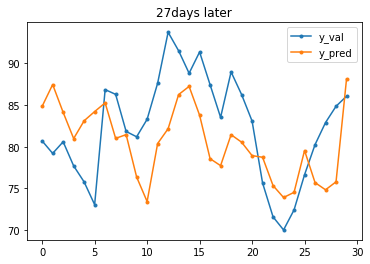

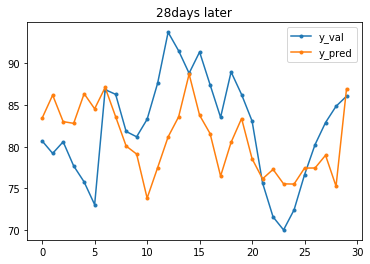

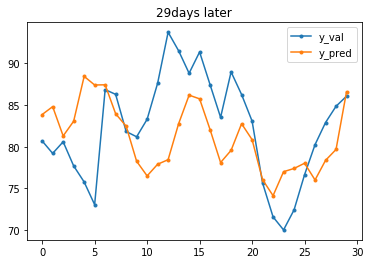

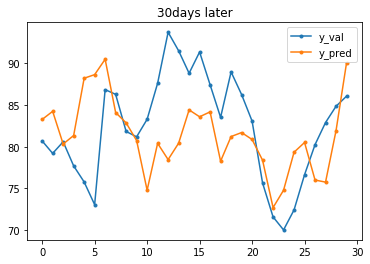

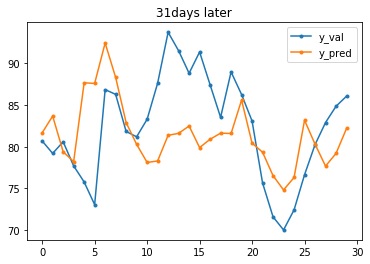

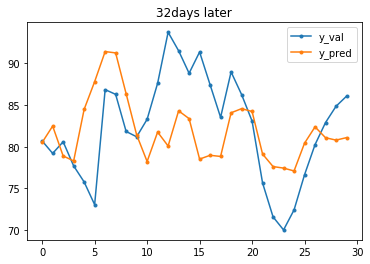

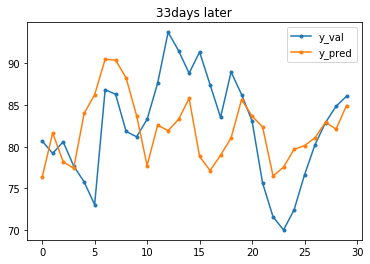

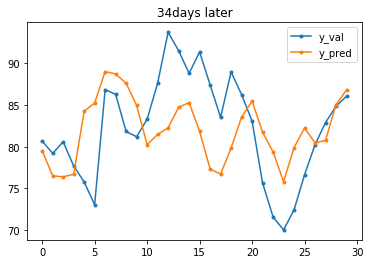

In [37]:
x_columns = ['year', 'month', 'day', 'dayofweek', 'supply', 'temp_max', 'temp_min', 'temp_mean']
y_columns = ['supply']
supply_models = {}

# 7일~34일 후를 예측하는 각각의 모델 구축
for future in range(7, 35):
    train_split = target.shape[0]-past-future-30 # 마지막 30일을 validation set으로 사용
    x_train, y_train = trans(target, 0, train_split, past, future, x_columns, y_columns)
    x_val, y_val = trans(target, train_split, None, past, future, x_columns, y_columns)

    supply_models[future] = Ridge().fit(x_train, y_train)
    
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.plot(np.array(y_val), '.-', label='y_val')
    plt.plot(supply_models[future].predict(x_val), '.-', label='y_pred')
    plt.title(str(future)+'days later')
    plt.legend()
    plt.show()
    
    print('==========================================================================')

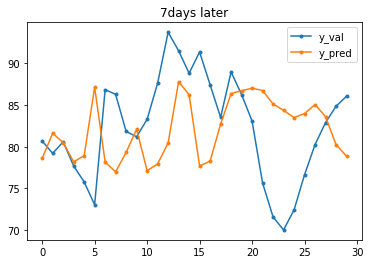

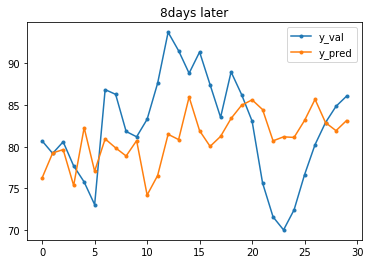

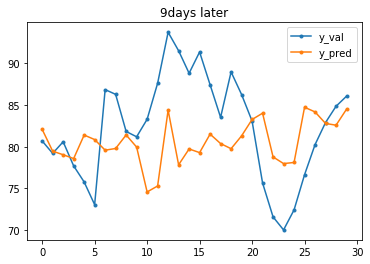

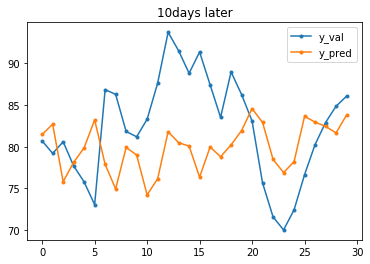

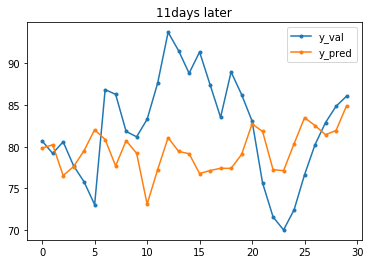

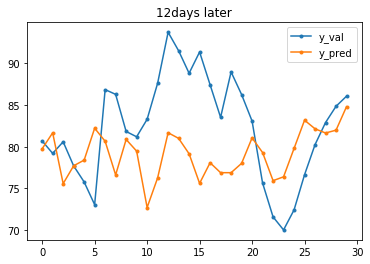

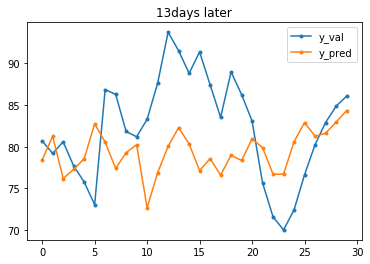

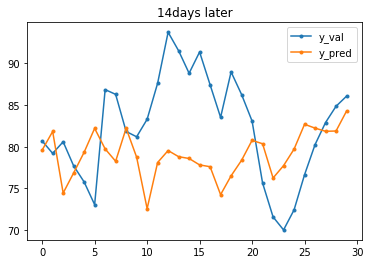

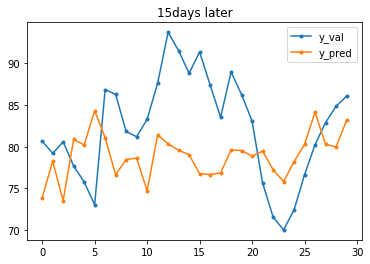

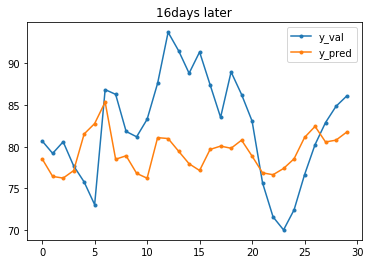

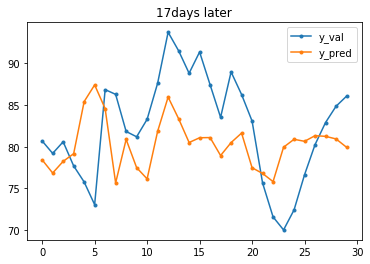

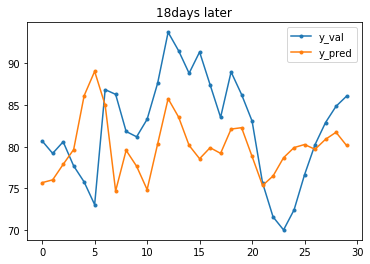

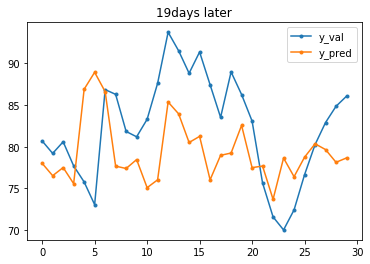

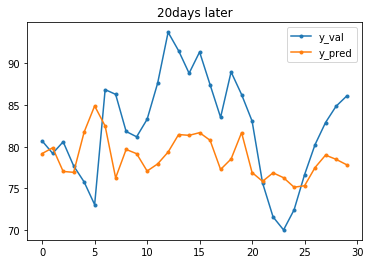

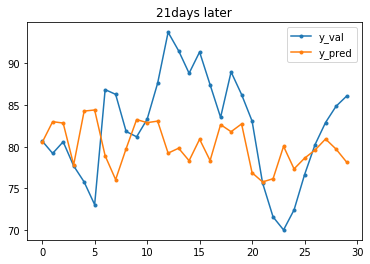

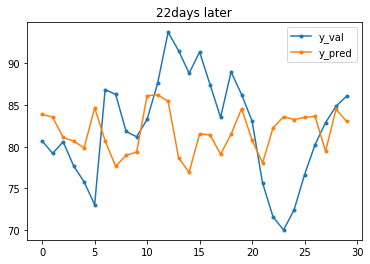

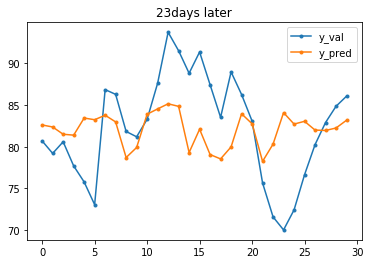

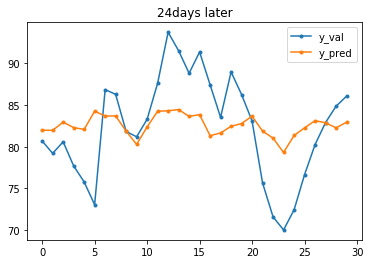

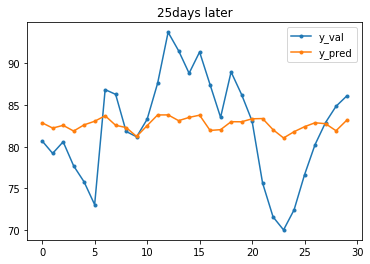

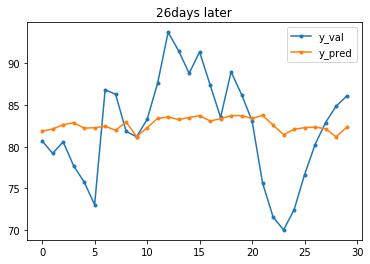

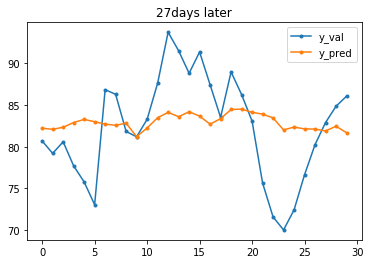

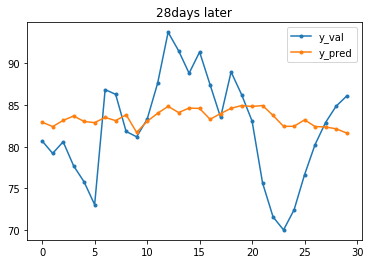

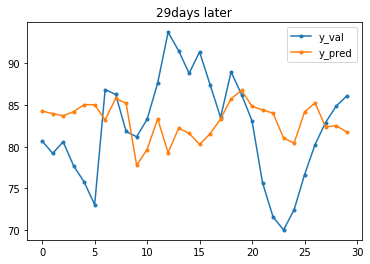

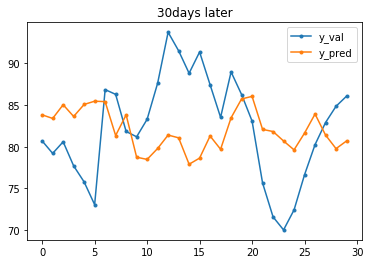

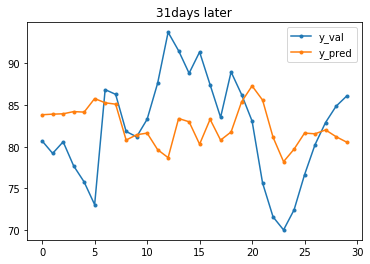

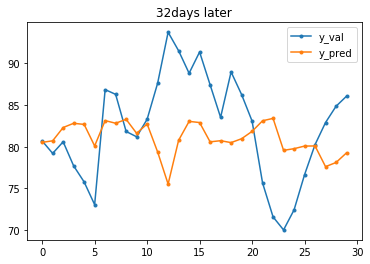

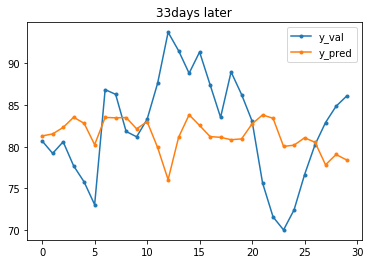

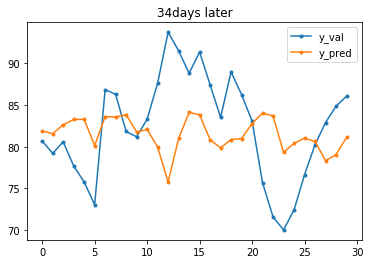

In [34]:
x_columns = ['year', 'month', 'day', 'dayofweek', 'supply', 'temp_max', 'temp_min', 'temp_mean']
y_columns = ['supply']
supply_models = {}

# 7일~34일 후를 예측하는 각각의 모델 구축
for future in range(7, 35):
    train_split = target.shape[0]-past-future-30 # 마지막 30일을 validation set으로 사용
    x_train, y_train = trans(target, 0, train_split, past, future, x_columns, y_columns)
    x_val, y_val = trans(target, train_split, None, past, future, x_columns, y_columns)

    supply_models[future] = create_model(x_train, y_train, x_val, y_val)
    print('==========================================================================')

In [ ]:
x_columns = ['year', 'month', 'day', 'temp_max', 'temp_min', 'temp_mean']

In [ ]:
y_columns = ['temp_max']
temp_max_models = {}

# 7일~34일 후를 예측하는 각각의 모델 구축
for future in range(7, 35):
    train_split = target.shape[0]-past-future-30
    x_train, y_train = trans(target, 0, train_split, past, future, x_columns, y_columns)
    x_val, y_val = trans(target, train_split, None, past, future, x_columns, y_columns)
    
    supply_models[future] = create_model(x_train, y_train, x_val, y_val)
    print('==========================================================================')

In [ ]:
y_columns = ['temp_min']
temp_min_models = {}

# 7일~34일 후를 예측하는 각각의 모델 구축
for future in range(7, 35):
    train_split = target.shape[0]-past-future-30
    x_train, y_train = trans(target, 0, train_split, past, future, x_columns, y_columns)
    x_val, y_val = trans(target, train_split, None, past, future, x_columns, y_columns)

    supply_models[future] = create_model(x_train, y_train, x_val, y_val)
    print('==========================================================================')

In [ ]:
y_columns = ['temp_mean']
temp_mean_models = {}

# 7일~34일 후를 예측하는 각각의 모델 구축
for future in range(7, 35):
    train_split = target.shape[0]-past-future-30
    x_train, y_train = trans(target, 0, train_split, past, future, x_columns, y_columns)
    x_val, y_val = trans(target, train_split, None, past, future, x_columns, y_columns)

    supply_models[future] = create_model(x_train, y_train, x_val, y_val)
    print('==========================================================================')

In [ ]:
x_test = np.array(target.loc[700:, ['year', 'month', 'day', 'dayofweek', 'supply', 'temp_max', 'temp_min', 'temp_mean']])
x_test = x_test.reshape(1,-1)

In [ ]:
supply_result=[]
for future in range(7, 35):
    supply_result.append(supply_models[future].predict(x_test))
supply_result = np.array(supply_result).reshape(-1)

In [ ]:
x_test = np.array(target.loc[700:, ['year', 'month', 'day', 'temp_max', 'temp_min', 'temp_mean']])
x_test = x_test.reshape(1,-1)

In [ ]:
temp_max_result=[]
for future in range(7, 35):
    temp_max_result.append(temp_max_models[future].predict(x_test))
temp_max_result = np.array(temp_max_result).reshape(-1)

In [ ]:
temp_min_result=[]
for future in range(7, 35):
    temp_min_result.append(temp_min_models[future].predict(x_test))
temp_min_result = np.array(temp_min_result).reshape(-1)

In [ ]:
temp_mean_result=[]
for future in range(7, 35):
    temp_mean_result.append(temp_mean_models[future].predict(x_test))
temp_mean_result = np.array(temp_mean_result).reshape(-1)

In [ ]:
submission = pd.read_csv('data/sample_submission.csv')
submission_bottom_half = submission.loc[28:,:]
submission = submission.loc[:27, :]
test = submission.copy()
test['date'] = pd.to_datetime(test['date'])
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day
test['dayofweek'] = test['date'].dt.dayofweek
test['supply'] = np.array(supply_result).reshape(-1)
test['temp_max'] = np.array(temp_max_result).reshape(-1)
test['temp_min'] = np.array(temp_min_result).reshape(-1)
test['temp_mean'] = np.array(temp_mean_result).reshape(-1)
test.head()

In [ ]:
def create_model(x_data, y_data, k=5):
    models = []
    
    k_fold = KFold(n_splits=k, shuffle=True, random_state=77)
    
    for train_idx, val_idx in k_fold.split(x_data):
        x_train, y_train = x_data.iloc[train_idx], y_data[train_idx]
        x_val, y_val = x_data.iloc[val_idx], y_data[val_idx]
    
#         d_train = lgb.Dataset(x_train, y_train)
#         d_val = lgb.Dataset(x_val, y_val)

#         params = {
#             'metric': 'mse',
#             'seed':777
#             }

#         model = lgb.train(params, d_train, 1000, d_val, verbose_eval=1000, early_stopping_rounds=100)

        model = get_trained_model(x_train, y_train, x_val, y_val)
        
        plt.rcParams['figure.figsize'] = [12, 4]
        plt.plot(np.array(y_val), '.-', label='y_val')
        plt.plot(model.predict(x_val), '.-', label='y_pred')
        plt.legend()
        plt.show()
        models.append(model)

    return models

In [ ]:
x_train = target.loc[:, ['supply', 'year', 'month', 'day', 'dayofweek', 'temp_max', 'temp_min', 'temp_mean']]
y_train = target.loc[:, ['smp_min', 'smp_max', 'smp_mean' ]]

smp_models = {}
for label in y_train.columns:
    print('train column : ', label)
    smp_models[label] = create_model(x_train, y_train[label])
    print('==========================================================================')

In [ ]:
x_test = test.loc[:,['supply', 'year', 'month', 'day', 'dayofweek', 'temp_max', 'temp_min', 'temp_mean']]
for label in ['smp_min', 'smp_max', 'smp_mean']:
    preds = []
    for i in range(5):
        preds.append(smp_models[label][i].predict(x_test))
    pred = sum(preds)/len(preds)
    test[label] = pred

In [ ]:
submission.loc[:, ['smp_min', 'smp_max', 'smp_mean', 'supply']] = test.loc[:,['smp_min', 'smp_max', 'smp_mean', 'supply']]
submission = pd.concat([submission, submission_bottom_half], axis = 0)
submission

In [ ]:
submission.to_csv('Catboost.csv', index=False)